# Problem 1.3 (Chamfer, Curvature & Normal Loss)

In [1]:
import sys
import time
import numpy as np
from tqdm.notebook import tqdm

# You can use other visualization from previous homeworks, like Open3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import torch
from torch import nn
from torch.functional import F

import trimesh
print("Trimesh version:", trimesh.__version__)

Trimesh version: 3.16.2


In [2]:
"""Visualization utilies."""
def show_points(points):
    fig = plt.figure(figsize=(14,8))
    ax = fig.gca(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points[:, 0], points[:, 2], points[:, 1])
    

def compare_points(points1, points2):
    fig = plt.figure(figsize=(14,8))
    ax = fig.gca(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points1[:, 0], points1[:, 2], points1[:, 1])
    ax.scatter(points2[:, 0], points2[:, 2], points2[:, 1])

In [3]:
# define device type - cuda:0 or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load data

In [5]:
"""Load data."""
source_pcd = trimesh.load("../data/source.obj")
target_pcd = trimesh.load("../data/target.obj")
print("Source PCD:", source_pcd)
print("Target PCD:", target_pcd)

source_vertices = source_pcd.vertices
source_faces = source_pcd.faces
target_vertices = target_pcd.vertices
target_faces = target_pcd.faces

num_src_pts = source_vertices.shape[0]
num_tgt_pts = target_vertices.shape[0]
num_src_faces = source_faces.shape[0]
num_tgt_faces = target_faces.shape[0]

Source PCD: <trimesh.Trimesh(vertices.shape=(962, 3), faces.shape=(1920, 3))>
Target PCD: <trimesh.Trimesh(vertices.shape=(1502, 3), faces.shape=(3000, 3))>


### Convert numpy data to torch tensor

In [6]:
src_vtx_ten = torch.clone(torch.tensor(source_vertices)).to(device)
src_faces_ten = torch.clone(torch.tensor(source_faces)).to(device)
tgt_vtx_ten = torch.clone(torch.tensor(target_vertices)).to(device)
tgt_faces_ten = torch.clone(torch.tensor(target_faces)).to(device)

In [7]:
def plot_mesh_3d(vertices, faces, plt_title):
    # Creating figure
    fig = plt.figure(figsize=(14, 9))
    ax = plt.axes(projection ='3d')

    # Creating color map
    my_cmap = cm.get_cmap('rainbow')

    surf_plot = ax.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2],
                                triangles=faces,
                                cmap=my_cmap, 
                                linewidth = 0.1,
                                antialiased = True)

#     fig.colorbar(surf_plot, shrink=0.5, aspect=10)
    ax.set_title(plt_title, fontweight ='bold')
    ax.set_xlabel('X-axis', fontweight ='bold')
    ax.set_ylabel('Y-axis', fontweight ='bold')
    ax.set_zlabel('Z-axis', fontweight ='bold')
    plt.show()

In [8]:
def plot_meshes_3d(vertices1, faces1, vertices2, faces2, plt_title1, plt_title2):
    # Creating figure
    fig = plt.figure(figsize=(16, 10))
    # Creating color map
    my_cmap = cm.get_cmap('rainbow')
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf_plot = ax.plot_trisurf(vertices1[:,0], vertices1[:,1], vertices1[:,2],
                                triangles=faces1,
                                cmap=my_cmap, 
                                linewidth = 0.1,
                                antialiased = True)
    ax.set_title(plt_title1, fontweight ='bold')
    ax.set_xlabel('X-axis', fontweight ='bold')
    ax.set_ylabel('Y-axis', fontweight ='bold')
    ax.set_zlabel('Z-axis', fontweight ='bold')

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf_plot = ax.plot_trisurf(vertices2[:,0], vertices2[:,1], vertices2[:,2],
                                triangles=faces2,
                                cmap=my_cmap, 
                                linewidth = 0.1,
                                antialiased = True)
    ax.set_title(plt_title2, fontweight ='bold')
    ax.set_xlabel('X-axis', fontweight ='bold')
    ax.set_ylabel('Y-axis', fontweight ='bold')
    ax.set_zlabel('Z-axis', fontweight ='bold')
#     fig.colorbar(surf_plot, shrink=0.5, aspect=10)
    
    plt.show()

### Display source and target point clouds

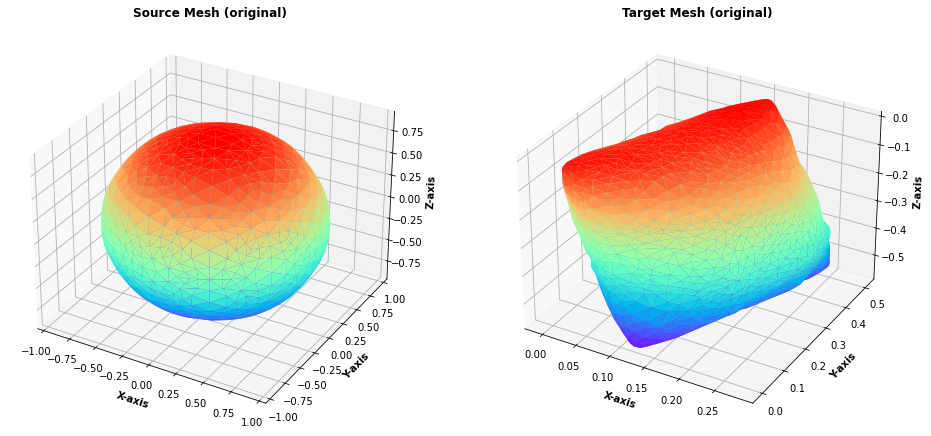

In [22]:
# show_points(source_vertices)
# show_points(target_vertices)
# compare_points(source_vertices, target_vertices)

plot_meshes_3d(source_vertices, 
               source_faces, 
               target_vertices, 
               target_faces, 
               "Source Mesh (original)", 
               "Target Mesh (original)")

### Function to compute adjacency matrix for any mesh

In [11]:
def get_adjacency_mat(faces, num_pts):
    num_faces = faces.shape[0]
    adj_mat = torch.zeros((num_pts, num_pts))

    for i in range(num_faces):
        vertex_lst = faces[i]
        adj_mat[vertex_lst[0], vertex_lst[1]] = 1
        adj_mat[vertex_lst[1], vertex_lst[0]] = 1

        adj_mat[vertex_lst[0], vertex_lst[2]] = 1
        adj_mat[vertex_lst[2], vertex_lst[0]] = 1

        adj_mat[vertex_lst[1], vertex_lst[2]] = 1
        adj_mat[vertex_lst[2], vertex_lst[1]] = 1

    return adj_mat

In [12]:
def get_Lnorm_mat(A_mat):
    num_pts = A_mat.shape[0]
    D_mat = torch.diag(torch.sum(A_mat, axis=1))
    L_mat = D_mat - A_mat
    D_inv = torch.linalg.inv(D_mat)
    Lnorm_mat = torch.eye(num_pts) - torch.matmul(D_inv, A_mat)
    
    return Lnorm_mat

In [16]:
# adjacency matrix not changing for src and tgt pcd. so just one time computation
src_adj_mat = get_adjacency_mat(src_faces_ten, num_src_pts)
tgt_adj_mat = get_adjacency_mat(tgt_faces_ten, num_tgt_pts)
print(src_adj_mat.shape, tgt_adj_mat.shape)

# Lnorm matrix not changing for src and tgt pcd. so just one time computation
src_Lnorm_mat = get_Lnorm_mat(src_adj_mat)
tgt_Lnorm_mat = get_Lnorm_mat(tgt_adj_mat)
print(src_Lnorm_mat.shape, tgt_Lnorm_mat.shape)

src_Lnorm_mat = src_Lnorm_mat.type(torch.DoubleTensor).to(device)
tgt_Lnorm_mat = tgt_Lnorm_mat.type(torch.DoubleTensor).to(device)

# deltaP not changing for tgt pcd. so just one time computation
src_deltaP = torch.matmul(src_Lnorm_mat, src_vtx_ten)
tgt_deltaP = torch.matmul(tgt_Lnorm_mat, tgt_vtx_ten)

torch.Size([962, 962]) torch.Size([1502, 1502])
torch.Size([962, 962]) torch.Size([1502, 1502])


### Function to compute chamfer loss

In [17]:
def compute_chamfer_loss(src_vertices, tgt_vertices):
    num_src_pts = src_vertices.shape[0]
    num_tgt_pts = tgt_vertices.shape[0]
    
    chamfer_loss = 0
    
    for i in range(num_src_pts):
        dists = torch.square(torch.linalg.norm(tgt_vertices - src_vertices[i], axis=1))
        chamfer_loss += torch.min(dists)
    
    for j in range(num_tgt_pts):
        dists = torch.square(torch.linalg.norm(src_vertices - tgt_vertices[j], axis=1))
        chamfer_loss += torch.min(dists)
    
    return chamfer_loss

### Below code iterates and deforms the source vertices towards target mesh using Chamfer Loss

In [18]:
chamfer_losses = []
num_itr = 400

weights_chamfer = nn.Parameter(torch.clone(src_vtx_ten)).to(device)

# Instantiate optimizer
optimizer = torch.optim.Adam([weights_chamfer], lr=0.005)

for _ in tqdm(range(num_itr)):
    loss = compute_chamfer_loss(weights_chamfer, tgt_vtx_ten)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    chamfer_losses.append(loss.item())

deformed_chamfer_vertices = weights_chamfer.cpu().detach().numpy()

  0%|          | 0/400 [00:00<?, ?it/s]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [19]:
deformed_chamfer_vertices = weights_chamfer.cpu().detach().numpy()

### Plot the variation of chamfer distance function with optimization iteration

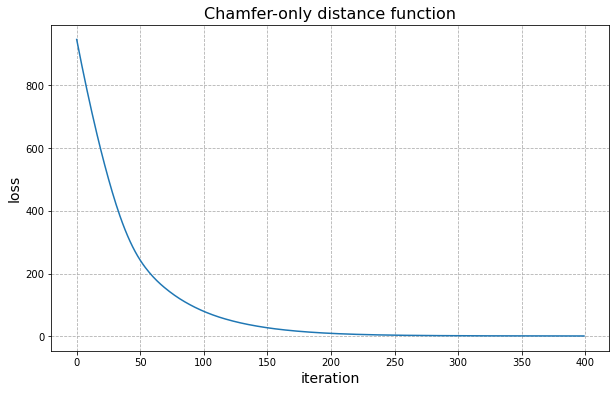

In [20]:
fig = plt.figure(figsize=(10, 6))
plt.plot(chamfer_losses)
plt.grid(linestyle='--')
plt.title("Chamfer-only distance function", fontsize=16)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.show()

### Result: Comparison between Target Mesh and Deformed Mesh using Chamfer Loss 

In [47]:
# compare_points(source_vertices, target_vertices)
# compare_points(weights.detach().numpy(), target_vertices)
# compare_points(src_vtx_ten, target_vertices)
# plot_mesh_3d(source_vertices, source_faces, "Source Mesh (original)")

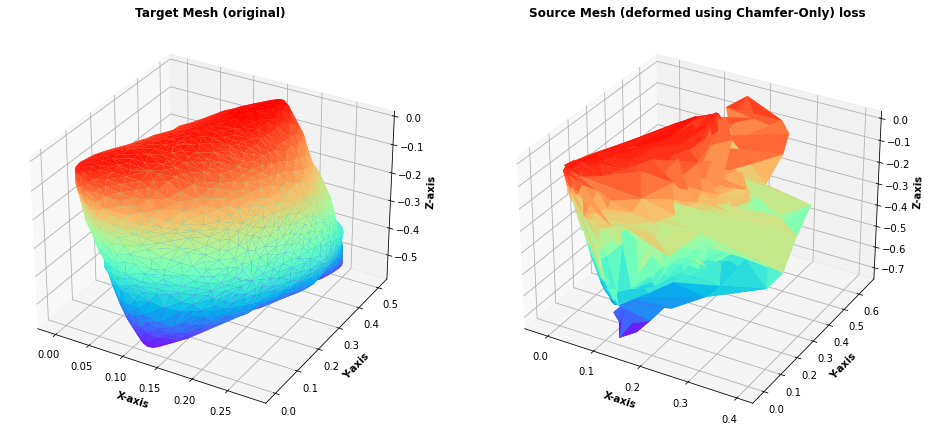

In [21]:
plot_meshes_3d(target_vertices, 
               target_faces, 
               deformed_chamfer_vertices, 
               source_faces, 
               "Target Mesh (original)", 
               "Source Mesh (deformed using Chamfer-Only) loss")

### Describe what has happened in the deformation process by language

- The source mesh is spherical (slightly elliptical) in shape, whereas the target mesh is rectangular at the boundaries but slighly spherical at the middle. 
- The chamfer loss measures the sum of the squared distances of each point in the source set to its nearest neighbour in the target set and vice-versa. The objective function in the part (a) optimization problem is the chamfer loss itself whereas the vertices of the source mesh are the optimization variables.
- The adam optimizer optimizes the vertices to minimize the chamfer distance loss function. Therefore, for each point in source mesh, the distance to nearest point in the target mesh is minimized which results in source vertices moving more closer to their corresponding nearest neighbors in target mesh.

### Function to compute Curvature + Chamfer loss

In [13]:
def compute_curvature_loss(src_vertices, tgt_vertices):
    num_src_pts = src_vertices.shape[0]
    num_tgt_pts = tgt_vertices.shape[0]
    
    # compute deltaP for src vertices / weight matrix
    src_deltaP = torch.matmul(src_Lnorm_mat, src_vertices)
    
    chamfer_loss = 0
    min_idx_lst = []
    
    for i in range(num_src_pts):
        dists = torch.square(torch.linalg.norm(tgt_vertices - src_vertices[i], axis=1))
        min_idx_lst.append(torch.argmin(dists))
        
        chamfer_loss += torch.min(dists)
    
    deltaP_src = torch.sum(torch.square(torch.linalg.norm(src_deltaP - tgt_deltaP[min_idx_lst], axis=1)))
    
    min_idx_lst = []
    
    for j in range(num_tgt_pts):
        dists = torch.square(torch.linalg.norm(src_vertices - tgt_vertices[j], axis=1))
        min_idx_lst.append(torch.argmin(dists))
        
        chamfer_loss += torch.min(dists)
    
    deltaP_tgt = torch.sum(torch.square(torch.linalg.norm(tgt_deltaP - src_deltaP[min_idx_lst], axis=1)))
    
    return chamfer_loss + deltaP_src + deltaP_tgt

### Below code iterates and deforms the source vertices towards target mesh using Curvature+Normal+Chamfer Loss

  0%|          | 0/400 [00:00<?, ?it/s]

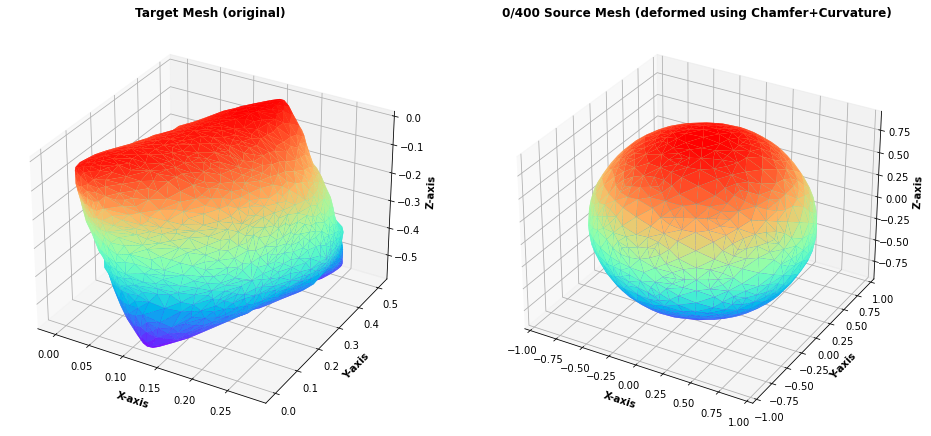

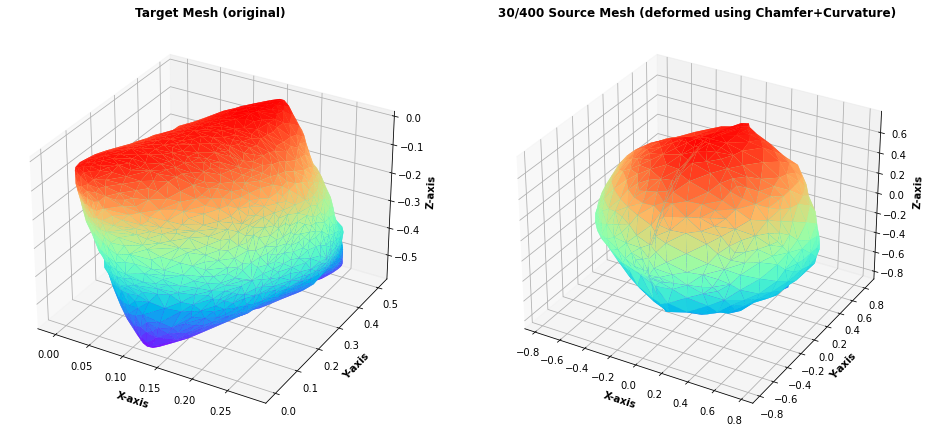

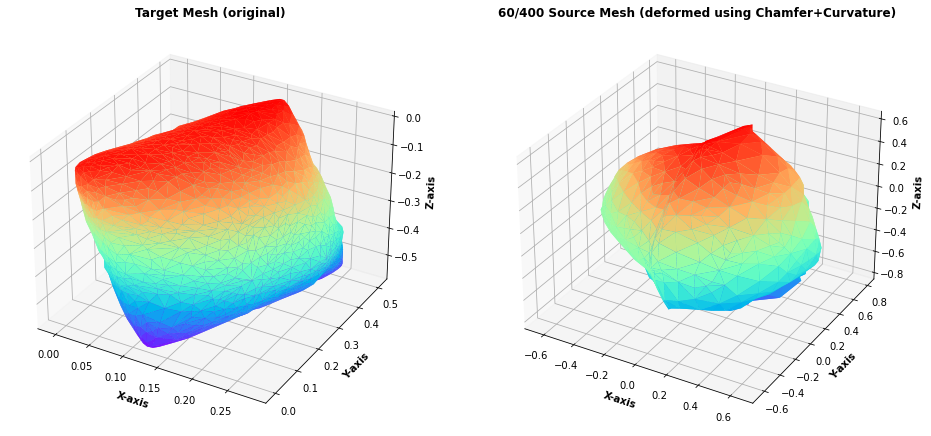

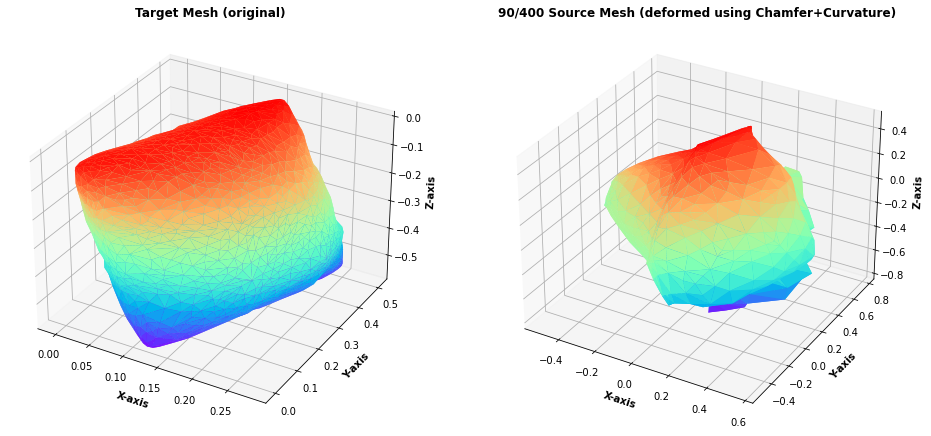

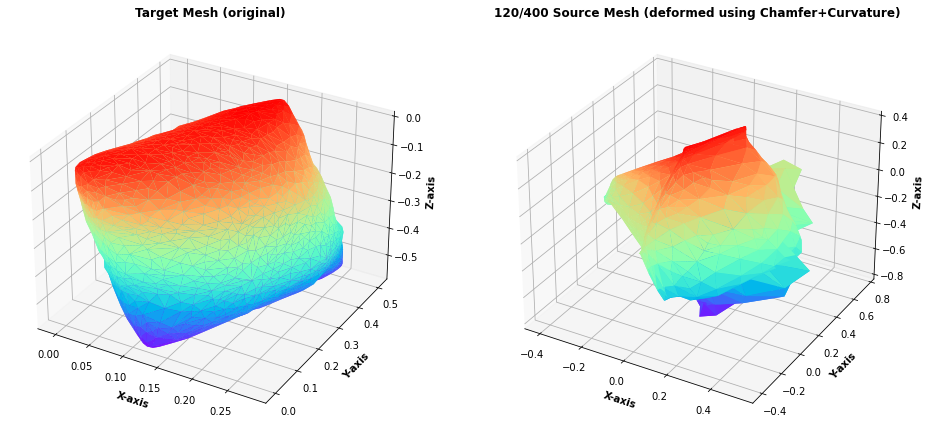

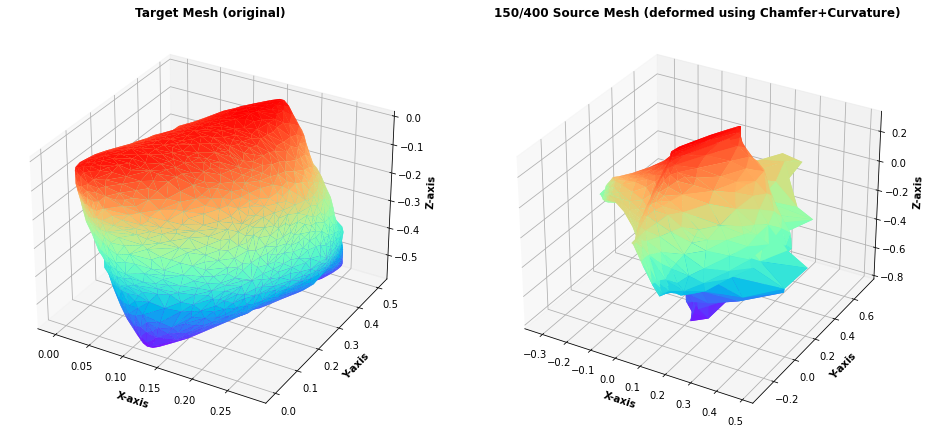

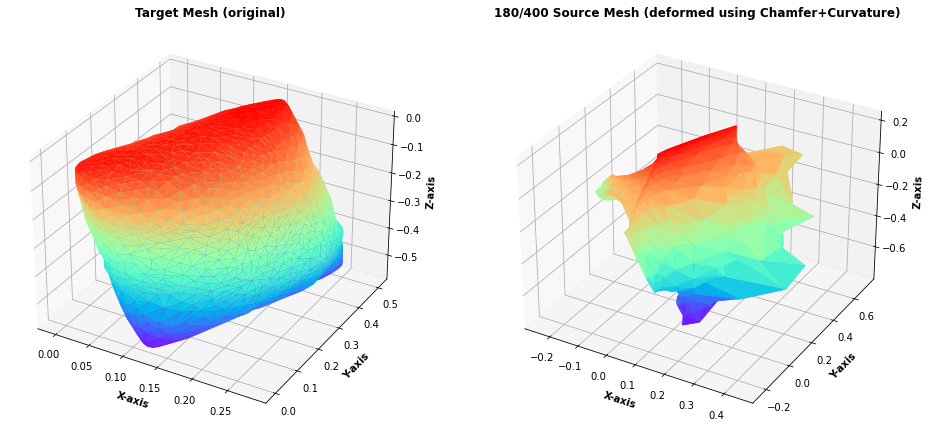

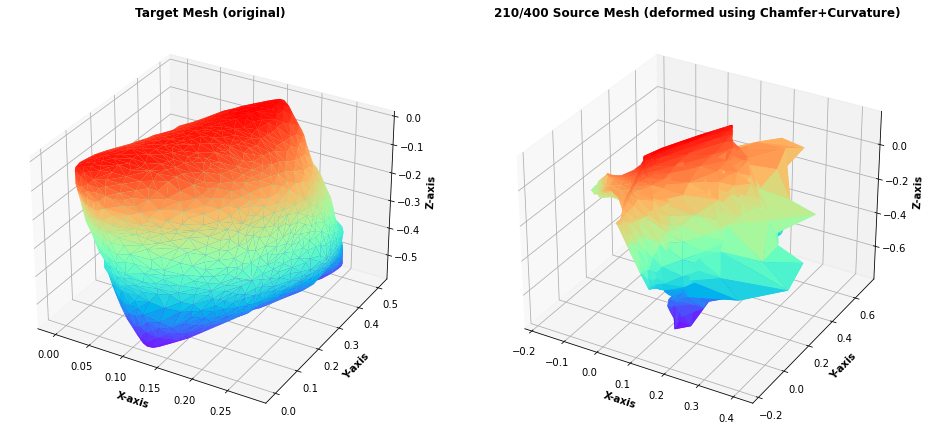

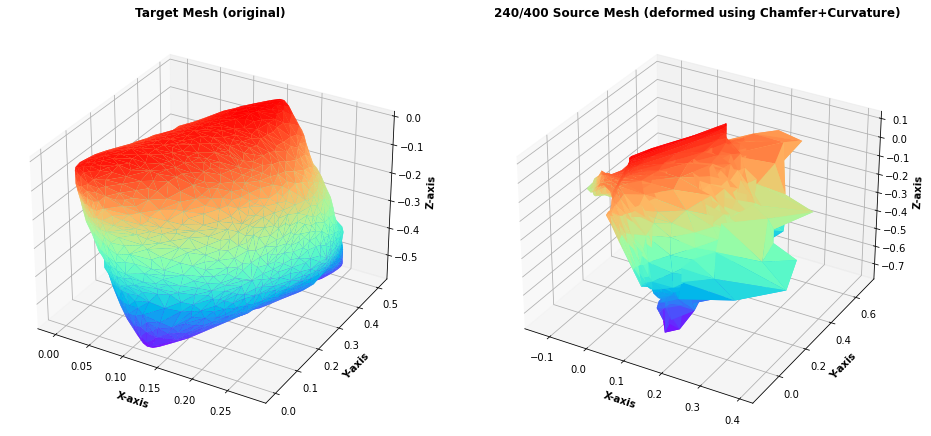

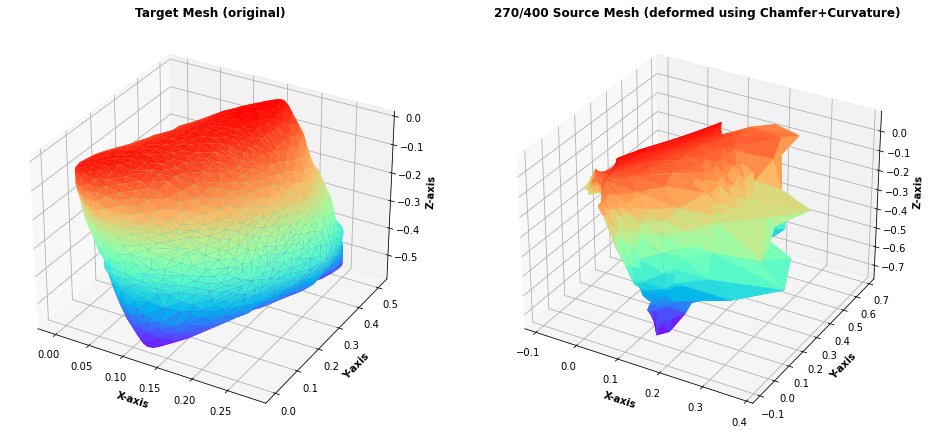

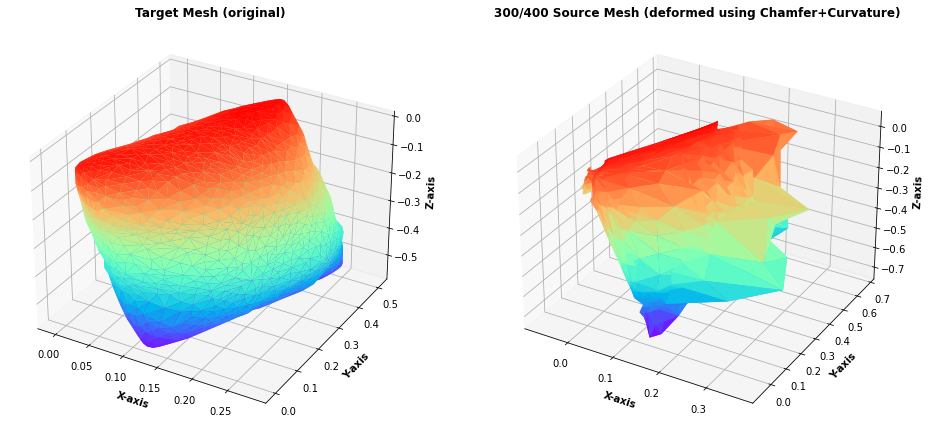

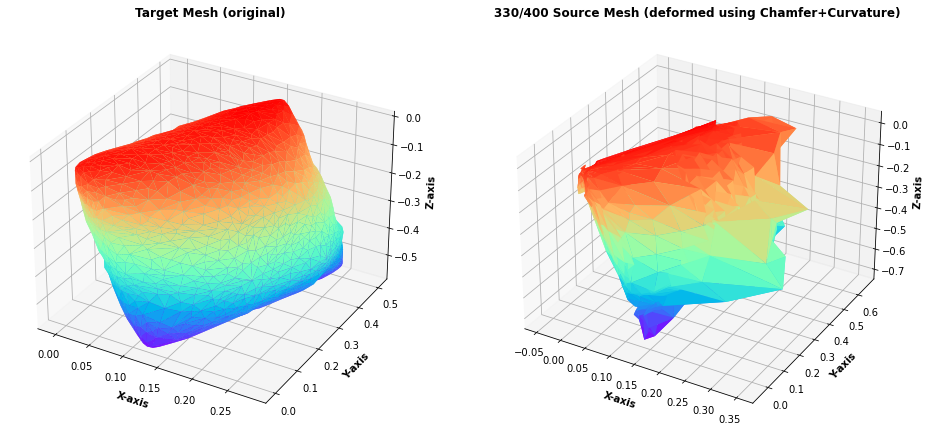

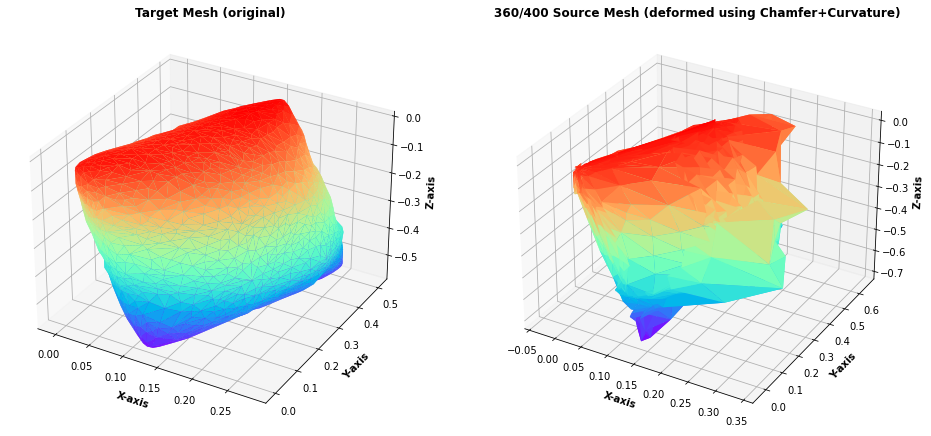

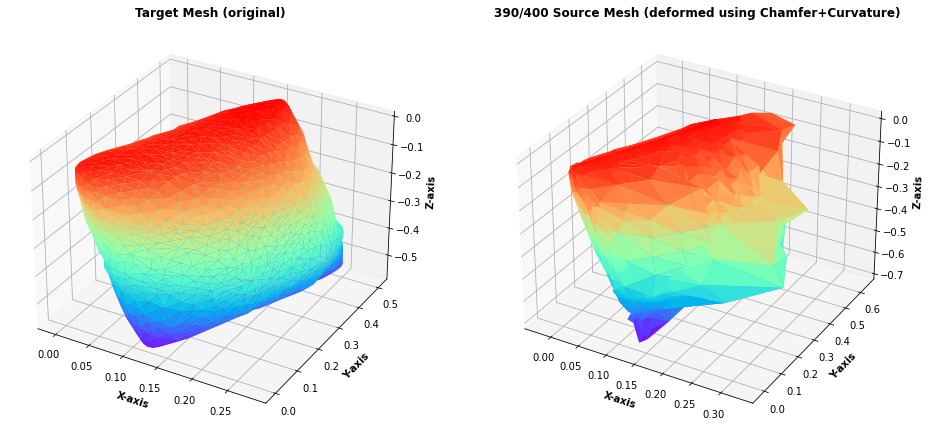

In [15]:
curv_losses = []
num_itr = 400

weights_curv = nn.Parameter(torch.clone(src_vtx_ten)).to(device)

# Instantiate optimizer
optimizer = torch.optim.Adam([weights_curv], lr=0.005)

for itr in tqdm(range(num_itr)):
    loss = compute_curvature_loss(weights_curv, tgt_vtx_ten)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    curv_losses.append(loss.item())
    
    if itr % 30 == 0:
        deformed_curv_vertices = weights_curv.cpu().detach().numpy()
        plot_meshes_3d(target_vertices, 
                       target_faces, 
                       deformed_curv_vertices, 
                       source_faces, 
                       "Target Mesh (original)", 
                       "{}/{} Source Mesh (deformed using Chamfer+Curvature)".format(itr, num_itr))

deformed_curv_vertices = weights_curv.cpu().detach().numpy()

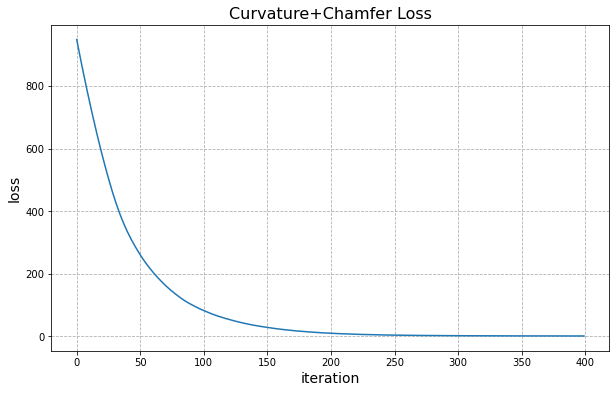

In [16]:
fig = plt.figure(figsize=(10, 6))
plt.plot(curv_losses)
plt.grid(linestyle='--')
plt.title("Curvature+Chamfer Loss", fontsize=16)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.show()

### Final Result: Comparison between Target Mesh and Deformed Mesh using Curvature+Chamfer Loss 

In [53]:
# compare_points(source_vertices, target_vertices)
# compare_points(weights.detach().numpy(), target_vertices)
# compare_points(src_vtx_ten, target_vertices)

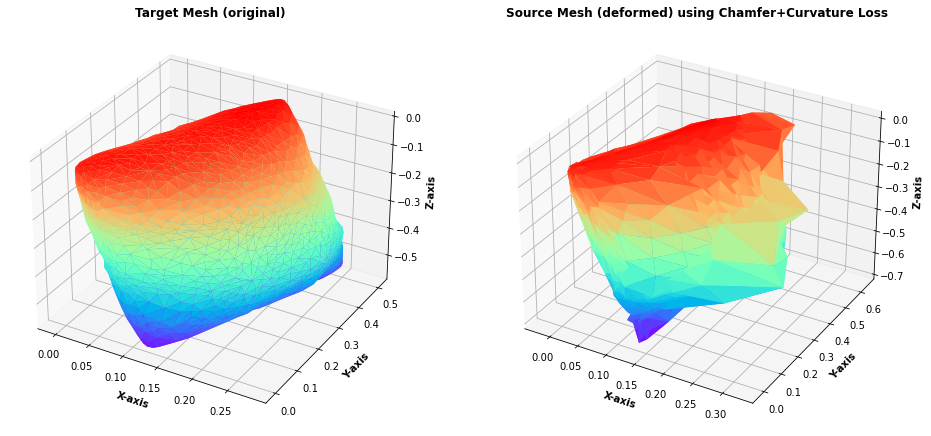

In [17]:
plot_meshes_3d(target_vertices, 
               target_faces, 
               deformed_curv_vertices, 
               source_faces, 
               "Target Mesh (original)", 
               "Source Mesh (deformed) using Chamfer+Curvature Loss")

## Problem 4 (Course Feedback)

#### 1. How many hours did you spend on this homework?
- Approximately 75-100 hrs

#### 2. How many hours did you spend on the course each week?
- In general, aside from the assignments, I spend roughly 7-8 hrs on this course/week (including lectures).

#### 3. Do you have any course related feedback?
- No.

In [16]:
src_pt = source_vertices[1]
print(src_pt)

dist = torch.linalg.norm(torch.tensor(target_vertices) - torch.tensor(src_pt), axis=1)
print(dist.shape)
dist_sq = torch.square(dist)
print(dist_sq.shape)
print(dist)
print(dist_sq)
print(torch.argmin(dist_sq).item(), torch.min(dist_sq).item())

print(dist_sq[283])

[ 0.134695 -0.895671  0.212918]
torch.Size([1502])
torch.Size([1502])
tensor([1.1639, 1.1821, 1.1724,  ..., 1.3938, 1.3699, 1.3915],
       dtype=torch.float64)
tensor([1.3546, 1.3975, 1.3744,  ..., 1.9426, 1.8765, 1.9362],
       dtype=torch.float64)
283 0.8750377632169999
tensor(0.8750, dtype=torch.float64)
